<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

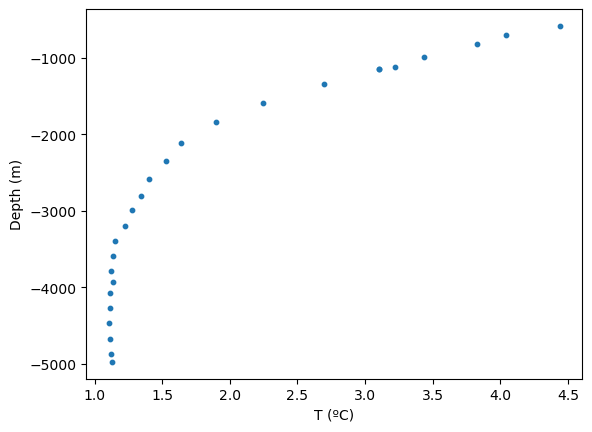

In [1]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation. 

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater. 

2024-10-31 16:24:41,735 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+00/s


Text(0, 0.5, 'Depth (m)')

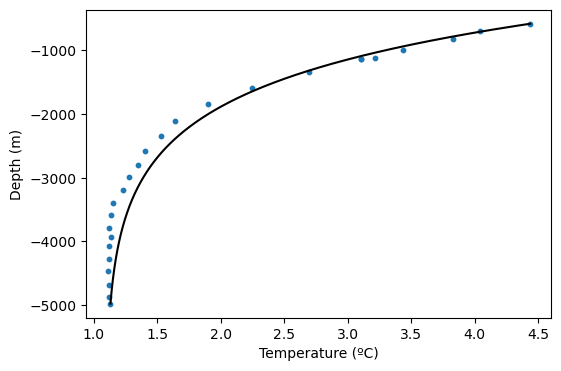

In [2]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature 
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=1e-4 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10) 
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water. 

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data. 

ADD DISCUSSION HERE

1. A diffusivity of kappa=1e-4 # m^2/s fits the data in the surface ocean (d<2000m) better and a diffusivity of kappa=8.5e-5 fits the data in the deep ocean better.

    This could be because the surface ocean water is more stratified so has a smaller diffusivity whereas the deep water is from the poles and so is older, more well mixed and uniform, hence has a larger diffusivity.


### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1e-5 m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$. 

2024-10-31 17:30:22,926 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


Text(0, 0.5, 'Depth (m)')

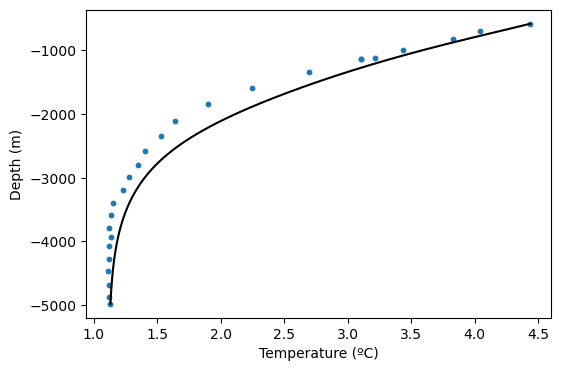

In [17]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature 
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 0.000000001 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)


#set Kbg and ko to be variables
Kbg=1e-5
Ko=8.6e-4


# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g'] = Kbg + (Ko-Kbg)*np.exp((-5e3-z)/667) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

list=[1e-5,1e-6,1e-7]

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')


2024-10-31 17:32:03,627 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s
2024-10-31 17:32:03,718 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+01/s
2024-10-31 17:32:03,792 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+01/s
2024-10-31 17:32:03,868 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+01/s
2024-10-31 17:32:03,944 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+01/s
2024-10-31 17:32:04,023 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s
2024-10-31 17:32:04,098 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+01/s


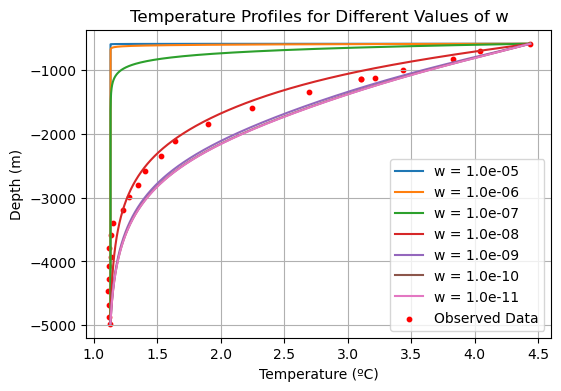

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging

logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature 
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)

# Set the diffusivity profile
kappa['g'] = 1e-5 + (8.6e-4 - 1e-5) * np.exp((-5e3 - z) / 667)  # m²/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# List of values for w to loop over
w_values = [1e-5, 1e-6, 1e-7, 1e-8,1e-9,1e-10,1e-11]

# Initialize the plot
plt.figure(figsize=(6, 4))

# Loop over different values of w
for w in w_values:
    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Plot results
    Tg = T['g']
    plt.plot(Tg, z, label=f'w = {w:.1e}')  # Plotting each result with its corresponding w value

# Scatter plot of CTD data
plt.scatter(CTD_T, CTD_z, s=10, color='red', label='Observed Data')

# Labels and legend
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.title('Temperature Profiles for Different Values of w')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


2024-10-31 17:54:21,260 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s
2024-10-31 17:54:21,350 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s
2024-10-31 17:54:21,428 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+01/s
2024-10-31 17:54:21,506 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+01/s


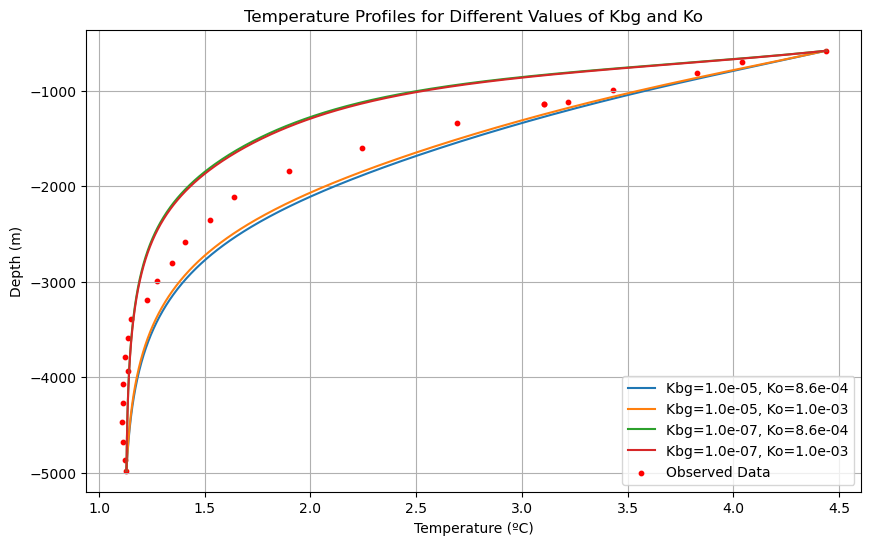

In [27]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging

logger = logging.getLogger(__name__)

# Set various parameters
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 0.000000001  # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# List of Kbg and Ko values to loop over
Kbg_values = [1e-5, 1e-7]
Ko_values = [8.6e-4,  1e-3]

# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop over different values of Kbg and Ko
for Kbg in Kbg_values:
    for Ko in Ko_values:
        # Fields
        T = dist.Field(name='T', bases=zbasis)  # Temperature field
        kappa = dist.Field(name='kappa', bases=zbasis)

        # Set the diffusivity
        kappa['g'] = Kbg + (Ko - Kbg) * np.exp((-5e3 - z) / 667)  # m²/s

        # Add two tau variables for boundary conditions
        tau_1 = dist.Field(name='tau_1')
        tau_2 = dist.Field(name='tau_2')
        lift_basis = zbasis.derivative_basis(1)
        lift = lambda A: d3.Lift(A, lift_basis, -1)

        # Substitutions
        dz = lambda A: d3.Differentiate(A, zcoord)
        Tz = dz(T) + lift(tau_1)

        # Problem
        problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
        problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
        problem.add_equation("T(z=z_surface) = T_surface")  # Boundary condition at surface
        problem.add_equation("T(z=z_bottom) = T_bottom")    # Boundary condition at bottom

        # Solver
        solver = problem.build_solver()
        solver.solve()

        # Plot results
        Tg = T['g']
        plt.plot(Tg, z, label=f'Kbg={Kbg:.1e}, Ko={Ko:.1e}')

# Labels and legend
plt.scatter(CTD_T, CTD_z, s=10, color='red', label='Observed Data')  # Optional observed data
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.title('Temperature Profiles for Different Values of Kbg and Ko')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


2024-10-31 18:00:17,951 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


Text(0, 0.5, 'Depth (m)')

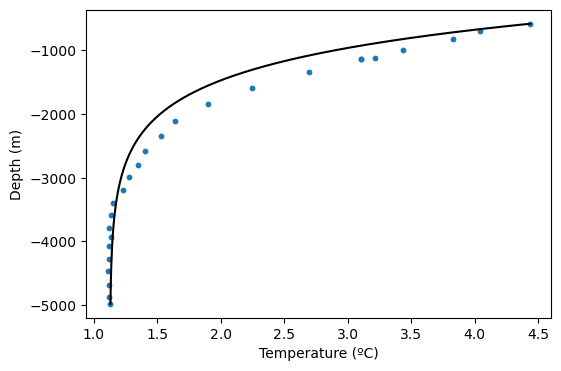

In [ ]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature 
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 0.000000001 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)


#set Kbg and ko to be variables
Kbg=1e-7
Ko=10


# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g'] = Kbg + (Ko-Kbg)*np.exp((-5e3-z)/667) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

list=[1e-5,1e-6,1e-7]

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')


### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

INSERT COMMENTS HERE

1. The density profile being resonalble with an downwelling velocity of 0 suggestst that the diffusive mixing alone can cause a diffusive heat flux that is sufficient to match the observed temperature profile.

2. Plotting profiles using a variety of vertical velocities suggests a vertical velocity of w=1e-8 produces a better agreement with the obervations. 

3. Plotting profiles using w=1e-8 and varying Ko and Kbg in the $\kappa(z)$ profile suggest the optimal w is very sensitive to the choice of k(z). 

(For example a larger diffusivity in the deep ocean (Ko) requires less upwelling to match the obserations??)

3- Areas of rough topography have a larger Ko and the roughness causes more turbulent mixing in the deep hence there is less stratification so it is easier for waters to move and for ocean circulation to occur. also the diffusive lngthscale could change ie if there is large mountain on the seafloor.

## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as 

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the spatially-dependent advection/diffusion equation. We will model the addition of pollution by adding a time-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [4]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])]; 

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

2024-10-31 16:39:47,889 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s
2024-10-31 16:39:47,893 __main__ 0/1 INFO :: Starting main loop
2024-10-31 16:39:49,068 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00
2024-10-31 16:39:49,085 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00
2024-10-31 16:39:49,103 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00
2024-10-31 16:39:49,120 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00
2024-10-31 16:39:49,137 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00
2024-10-31 16:39:49,154 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00
2024-10-31 16:39:49,171 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00
2024-10-31 16:39:49,188 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00
2024-10-31 16:39:49,205 __main__ 0/1 INFO :: Iteratio

## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you install ffmpeg with the command: 

`conda install -c conda-forge ffmpeg`

2024-10-31 16:39:56,972 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-10-31 16:39:56,974 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/v7/2sjr043x4fx6zqy90y0m22hr0000gn/T/tmp29vd6hvk/temp.m4v


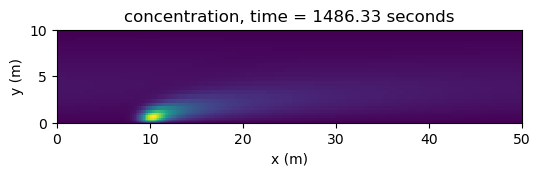

In [5]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)   
    plt.ylim(0, w)  
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

No concentration data for x=5 m
No concentration data for x=15 m
No concentration data for x=25 m
No concentration data for x=35 m
No concentration data for x=45 m


/var/folders/v7/2sjr043x4fx6zqy90y0m22hr0000gn/T/ipykernel_76193/3729981977.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


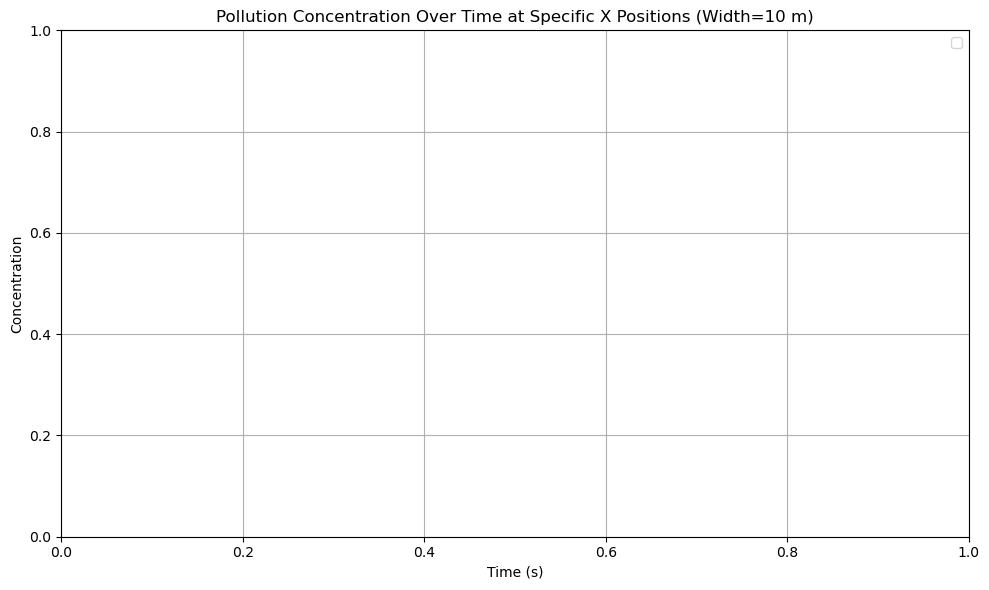

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define specific x positions along the river for which to plot concentration
x_positions = [5, 15, 25, 35, 45]  # Example positions along the x-axis

# Create a figure for the plot
plt.figure(figsize=(10, 6))

# Choose a fixed width for the simulation
fixed_width = 10  # Adjust based on your actual simulation width

# Loop through each specified x position
for x in x_positions:
    # Check if concentration data exists for the specified width and x position
    if x in results[fixed_width]['concentration_over_time']:
        concentration = np.array(results[fixed_width]['concentration_over_time'][x])
        time = results[fixed_width]['t_save']

        # Ensure both arrays are not empty
        if concentration.size > 0 and time.size > 0:
            plt.plot(time, concentration, label=f'x={x} m')
        else:
            print(f"No data available for x={x} m: Time size = {time.size}, Concentration size = {concentration.size}")
    else:
        print(f"No concentration data for x={x} m")

# Configure plot aesthetics
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title(f'Pollution Concentration Over Time at Specific X Positions (Width={fixed_width} m)')
plt.legend()
plt.grid()
plt.tight_layout()  # Adjust layout
plt.show()


INSERT PLOTS AND COMMENTS HERE

1. To calculate the time needed for pollution to reach the other side of the river ignore the advection term in the diffusion-advection equation and non dimensionalise the equaiton to get $$t \sim x^2/\kappa = 10^2/0.001= 10^4s$$

2. To estimate the distance downstream that the pollution takes to reach the other side use the maximum velocity in the centre of the stream and: $$s=vt \sim 0.1*10^4 \sim 10^3m$$

    Note: the actual distance in 2. would be larger as the river current varies across the river so that average current would be lower than the maximum current. 



## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.